In [1]:
from google.colab import files
files.upload()

Saving water_potability.csv to water_potability.csv


{'water_potability.csv': b'ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability\r\n,204.8904554713363,20791.318980747026,7.300211873184757,368.51644134980336,564.3086541722439,10.3797830780847,86.9909704615088,2.9631353806316407,0\r\n3.71608007538699,129.42292051494425,18630.057857970347,6.635245883862,,592.8853591348523,15.180013116357259,56.32907628451764,4.500656274942408,0\r\n8.099124189298397,224.23625939355776,19909.541732292393,9.275883602694089,,418.6062130644815,16.868636929550973,66.42009251176368,3.0559337496641685,0\r\n8.316765884214679,214.37339408562252,22018.417440775294,8.05933237743854,356.88613564305666,363.2665161642437,18.436524495493302,100.34167436508008,4.628770536837084,0\r\n9.092223456290965,181.10150923612525,17978.98633892625,6.546599974207941,310.13573752420444,398.41081338184466,11.558279443446395,31.997992727424737,4.075075425430034,0\r\n5.584086638456089,188.3133237696164,28748.68773904612,7.5448687887796

In [53]:
%pip install -U imbalanced-learn

     |████████████████████████████████| 189 kB 8.7 MB/s 
     |████████████████████████████████| 23.1 MB 1.6 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
ds = pd.read_csv("/content/water_potability.csv")

In [3]:
print(ds.head())
print('\nSize of the dataset:', ds.shape)

         ph    Hardness        Solids  ...  Trihalomethanes  Turbidity  Potability
0       NaN  204.890455  20791.318981  ...        86.990970   2.963135           0
1  3.716080  129.422921  18630.057858  ...        56.329076   4.500656           0
2  8.099124  224.236259  19909.541732  ...        66.420093   3.055934           0
3  8.316766  214.373394  22018.417441  ...       100.341674   4.628771           0
4  9.092223  181.101509  17978.986339  ...        31.997993   4.075075           0

[5 rows x 10 columns]

Size of the dataset: (3276, 10)


In [4]:
ds.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [5]:
ds.isna().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [6]:
mv_cols = ['ph', 'Sulfate', 'Trihalomethanes']
imputer = KNNImputer(n_neighbors=5)
ds[mv_cols] = imputer.fit_transform(ds[mv_cols])

In [7]:
ds.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

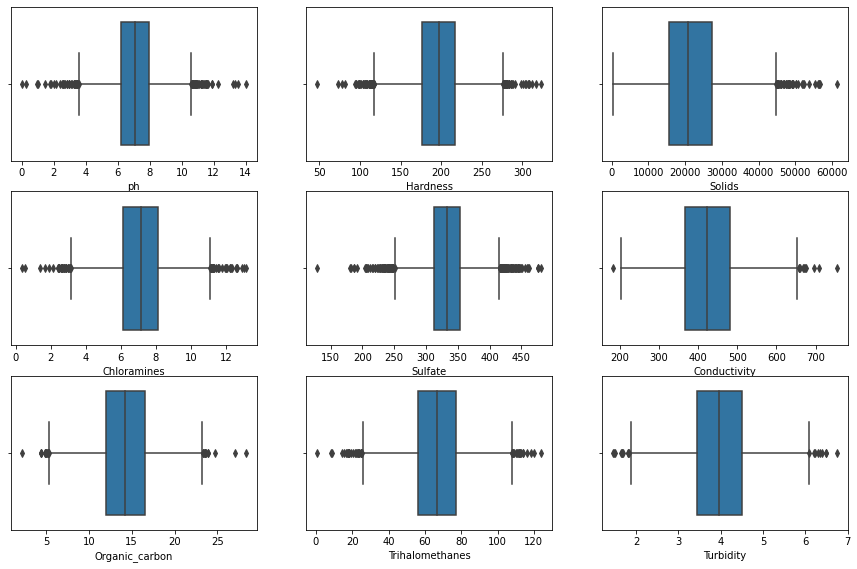

In [8]:
plt.figure(figsize=(15, 30))
for i, columns in enumerate(ds.drop('Potability', axis=1).columns):
    ax = plt.subplot(9, 3, i+1)
    sns.boxplot(x=ds[columns], ax=ax)
plt.show()

In [10]:
Q1 = ds[['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate',
        'Conductivity','Organic_carbon', 'Trihalomethanes', 'Turbidity']].quantile(0.25)
Q3 = ds[['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate',
        'Conductivity','Organic_carbon', 'Trihalomethanes', 'Turbidity']].quantile(0.75)

IQR = Q3 - Q1

min_val = Q1 - (1.5 * IQR)
max_val = Q3 + (1.5 * IQR)

lower_bound = (ds < min_val)
upper_bound = (ds > max_val)

ds_clean = ds.mask(lower_bound, min_val, axis=1)
ds_clean = ds_clean.mask(upper_bound, max_val, axis=1)

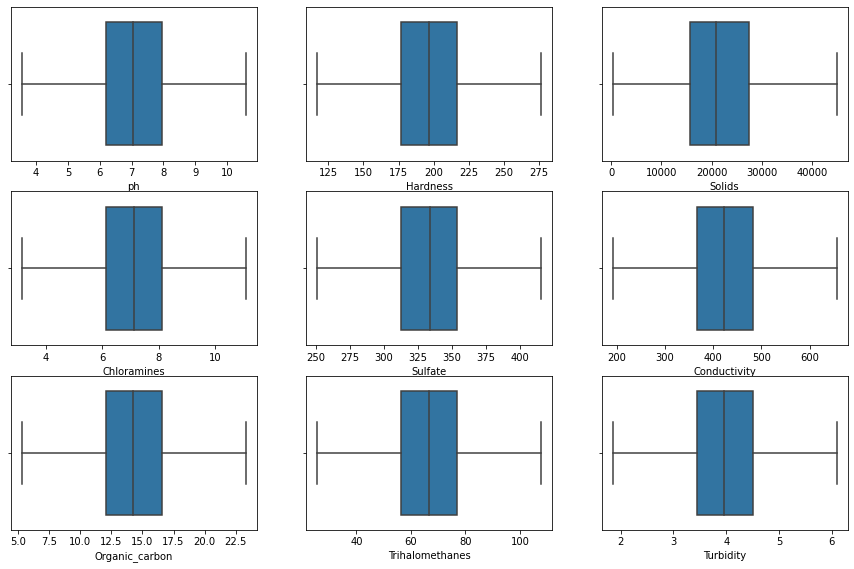

In [11]:
plt.figure(figsize=(15, 30))
for i, columns in enumerate(ds_clean.drop('Potability', axis=1).columns):
    ax = plt.subplot(9, 3, i+1)
    sns.boxplot(x=ds_clean[columns], ax=ax)
plt.show()

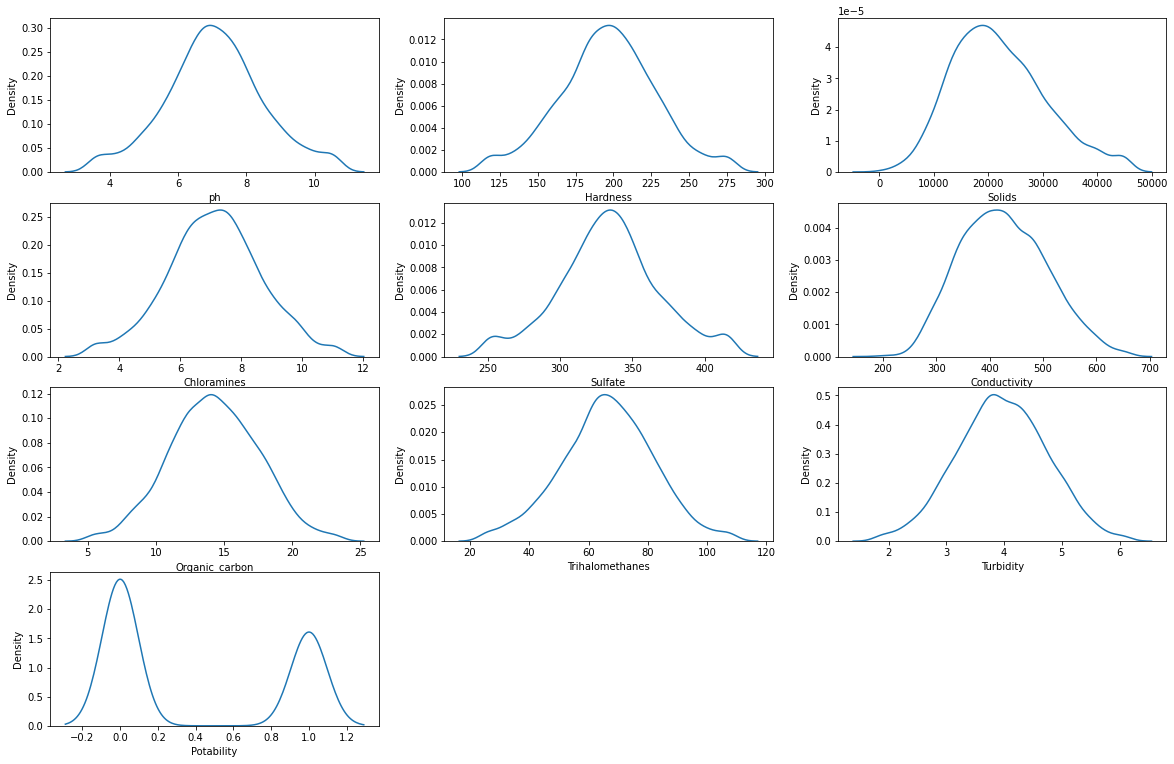

In [12]:
plt.figure(figsize=(20, 30))
for i, columns in enumerate(ds_clean.columns):
    ax = plt.subplot(9, 3, i+1)
    sns.kdeplot(x=ds_clean[columns], ax=ax)
plt.show()

In [95]:
X = ds_clean.drop("Potability", axis=1)
y = ds_clean["Potability"]

In [96]:
ros = RandomOverSampler(sampling_strategy=1)
X_ros, y_ros = ros.fit_resample(X, y)

In [50]:
X_ros.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,6.746642,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135
1,3.716080,129.422921,18630.057858,6.635246,334.506495,592.885359,15.180013,56.329076,4.500656
2,8.099124,224.236259,19909.541732,9.275884,321.768097,418.606213,16.868637,66.420093,3.055934
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075


In [39]:
y_ros.head()

0    0
1    0
2    0
3    0
4    0
Name: Potability, dtype: int64

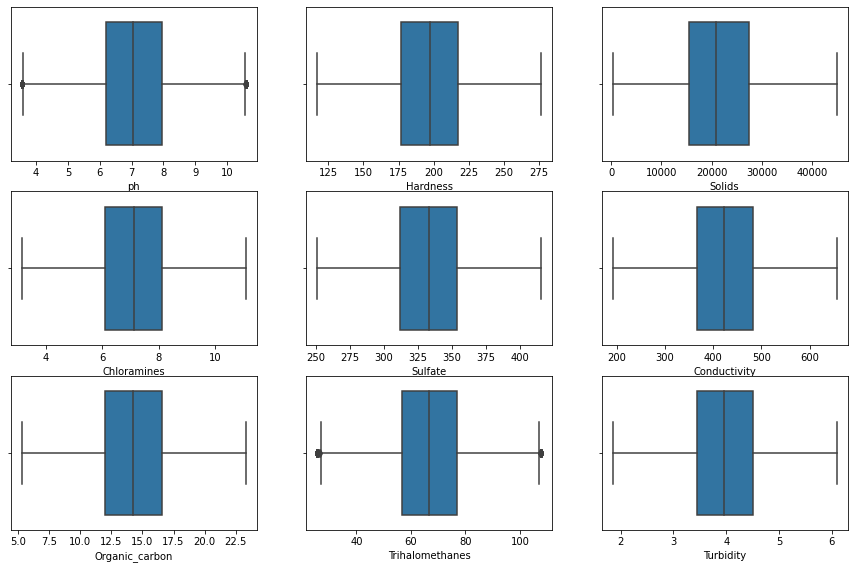

In [16]:
plt.figure(figsize=(15, 30))
for i, columns in enumerate(X_ros.columns):
    ax = plt.subplot(9, 3, i+1)
    sns.boxplot(x=X_ros[columns], ax=ax)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


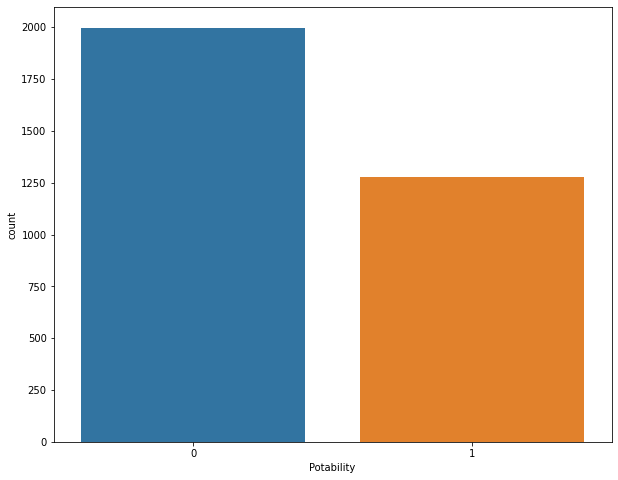

In [18]:
plt.figure(figsize=(10, 8))
sns.countplot(ds_clean['Potability'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


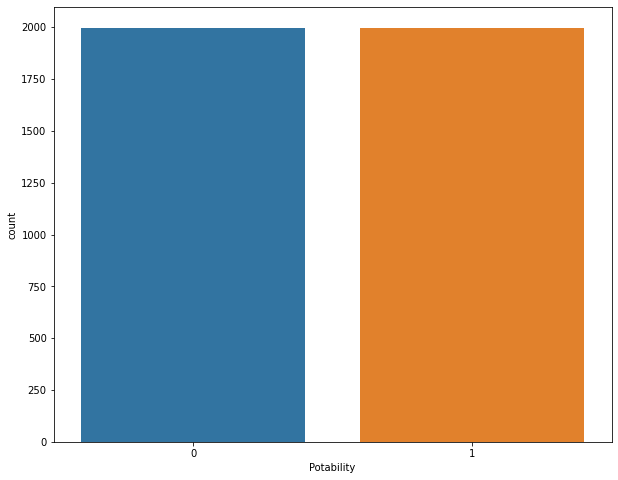

In [19]:
plt.figure(figsize=(10, 8))
sns.countplot(y_ros)
plt.show()

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.20, random_state=0)

In [41]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(random_state=0)
dtc.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 0,
 'splitter': 'best'}

In [51]:
grid = GridSearchCV(dtc, param_grid=dict(
                                        criterion=['gini', 'entropy']
), n_jobs=-1)
model = grid.fit(X_train, y_train)

NameError: ignored

In [89]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=0, verbose=1)
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 1,
 'warm_start': False}

In [97]:
grid = GridSearchCV(rfc, param_grid=dict(
                                        criterion=['gini', 'entropy'],
                                        n_jobs=[-1, 1, 2, 3, 4, 5]
), n_jobs=-1)
model = grid.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished


In [244]:
model.best_params_

{'criterion': 'gini', 'n_jobs': -1}

In [45]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [46]:
grid = GridSearchCV(knn, param_grid=dict(
                                        algorithm=['auto', 'ball_tree', 'kd_tree', 'brute'],
                                        weights=['uniform', 'distance'],
                                        n_neighbors=[1, 3, 5, 6],
                                        n_jobs=[-1, 1, 2, 4, 6, 8]
), n_jobs=-1)

model = grid.fit(X_train, y_train)

In [139]:
model.best_params_

{'algorithm': 'auto',
 'n_jobs': -1,
 'n_neighbors': 1,
 'p': 1,
 'weights': 'uniform'}

In [44]:
from sklearn.linear_model import RidgeClassifier

ridgeC = RidgeClassifier()
ridgeC.get_params()

{'alpha': 1.0,
 'class_weight': None,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': 'deprecated',
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [152]:
grid = GridSearchCV(ridgeC, param_grid=dict(alpha=np.linspace(1, 10, 10)), n_jobs=-1)
model = grid.fit(X_train, y_train)

In [48]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

gauss = GaussianNB()
gauss.get_params()

{'priors': None, 'var_smoothing': 1e-09}

In [101]:
grid = GridSearchCV(gauss, param_grid=dict(var_smoothing=np.logspace(-9, -1, 100)))
model = grid.fit(X_train, y_train)

In [104]:
multi = MultinomialNB()
multi.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

In [105]:
grid = GridSearchCV(multi, param_grid=dict(alpha=np.linspace(1, 10, 10)))
model = grid.fit(X_train, y_train)

In [148]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

ada_boost = AdaBoostClassifier()
ada_boost.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [149]:
model = ada_boost.fit(X_train, y_train)

In [64]:
from xgboost import XGBRFClassifier

xgbrf = XGBRFClassifier(random_state=0, n_jobs=-1)
xgbrf.get_params()

{'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bynode': 0.8,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 0.8,
 'verbosity': 1}

In [ ]:
grid = GridSearchCV(xgbrf, param_grid=dict(
    gamma=[0, 1, 3, 5, 6, 7]
))
model = grid.fit(X_train, y_train)

In [79]:
model.best_params_

{'gamma': 7, 'reg_alpha': 0.5, 'reg_lambda': 1}

In [98]:
prediction = model.predict(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


In [99]:
acc = accuracy_score(y_test, prediction)
print("Model score: {}".format(acc))

Model score: 0.77625


In [93]:
scoring = ['precision_macro', 'recall_macro', 'f1_macro']
scores = cross_validate(model, X_ros, y_ros, cv=6, scoring=scoring)
scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0

{'fit_time': array([58.70664859, 59.55626631, 59.38415647, 57.02556252, 60.65000677,
        57.84499407]),
 'score_time': array([0.11217761, 0.10857797, 0.10783863, 0.10764623, 0.10798836,
        0.1088593 ]),
 'test_f1_macro': array([0.66916546, 0.7120557 , 0.71032983, 0.68266163, 0.83345836,
        0.86710154]),
 'test_precision_macro': array([0.67071035, 0.72295001, 0.71583022, 0.68439542, 0.87755102,
        0.89642857]),
 'test_recall_macro': array([0.66966967, 0.71471471, 0.71171171, 0.68318318, 0.83783784,
        0.86936937])}

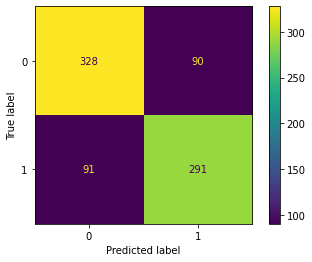

In [248]:
cm = confusion_matrix(y_test, prediction, labels=model.classes_)

vis = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

vis.plot()
plt.show()